<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li></ul></li><li><span><a href="#Подбор-параметров" data-toc-modified-id="Подбор-параметров-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Подбор параметров</a></span><ul class="toc-item"><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузим данные и выполним их ресемплирование по одному часу.
2. Проанализируем данные.
3. Обучим разные модели с различными гиперпараметрами. Сделаем тестовую выборку размером 10% от исходных данных.
4. Проверим данные на тестовой выборке и сделаем выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates = [0], index_col = [0])

In [3]:
data.head()


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.isnull().sum()

num_orders    0
dtype: int64

**Выводы**

- для анализа представленны данные с 1 марта 2018 года по 31 августа 2018 года
- пропусков в данных нет 

**Столбцы** 

- datetime  - время и дата заказа
- numorders - кол-во заказов

## Анализ

Будем ресемплировать данные. Посмотрим на  тренды и сезонность 

<AxesSubplot:xlabel='datetime'>

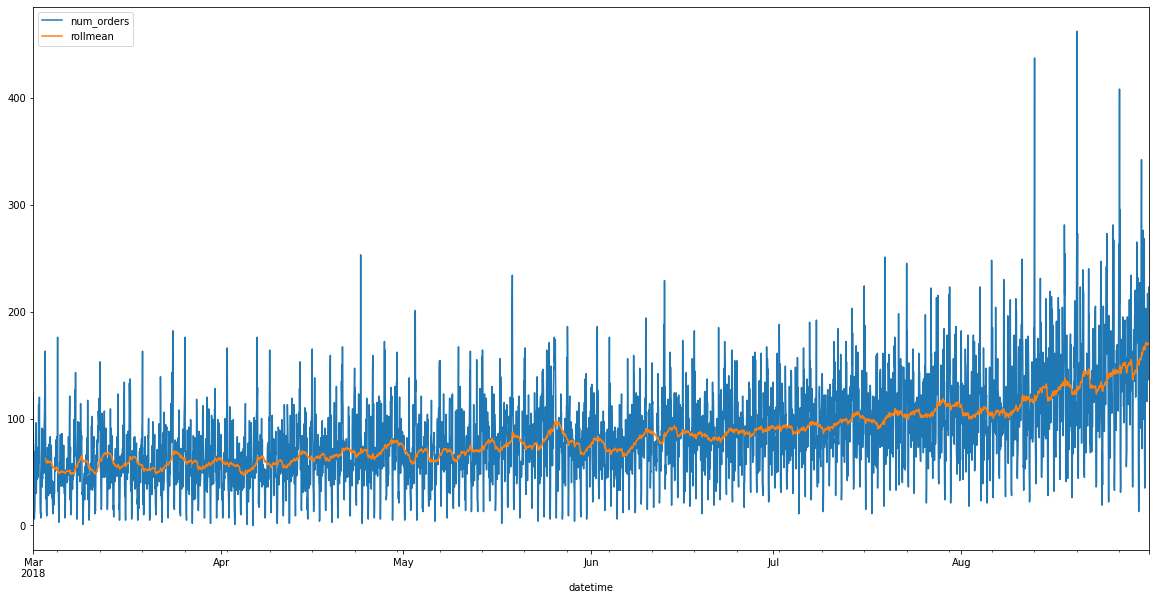

In [6]:
hours = data.resample('1H').sum()
hours['rollmean'] = hours['num_orders'].rolling(50).mean()
hours.plot(figsize = (20,10))

Text(0.5, 1.0, 'Заказы по месяцам')

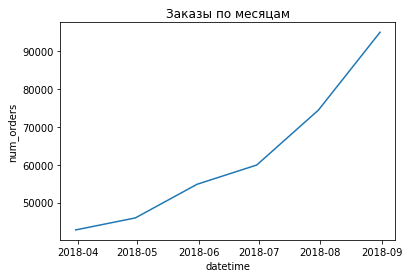

In [7]:
months = data.resample('1M').sum()
sns.lineplot(x=months.index,y=months['num_orders']).set_title('Заказы по месяцам')

Количество заказов начинает расти ближе к лету. Учитывая сезон отпусков это логично. Ну или на улице жарко становится и хочется доехать в прохладе кондиционреа авто. Или ты приятно попил вина у залива и теперь хочется доехать на такси до дома, потому что не трезвым за руль нельзя садиться. Чот меня понесло (лето хочется уже)

In [8]:
data = data.resample('1H').sum()


In [9]:
decomposed_data = seasonal_decompose(data)

посмотрим на данные в срезе за июль 

<AxesSubplot:title={'center':'Сезонность за 2 недели'}, xlabel='datetime'>

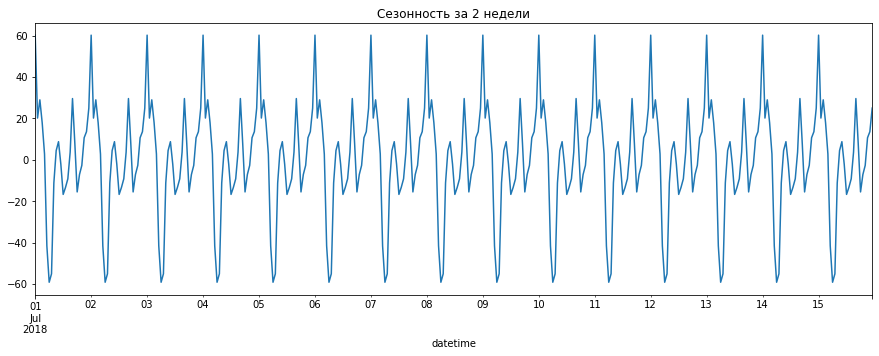

In [10]:
#decomposed_data.seasonal['2018-07-01':'2018-07-30'].plot(ax = plt.gca(), title = 'Сезонность за месяц', figsize = (15,5))
#как все сжато получилось, возьму промежуток в две недели
decomposed_data.seasonal['2018-07-01':'2018-07-15'].plot(ax = plt.gca(), title = 'Сезонность за 2 недели', figsize = (15,5))

Посмотрим на сезонность в течении дня

<AxesSubplot:title={'center':'Сезонность за 2 недели'}, xlabel='datetime'>

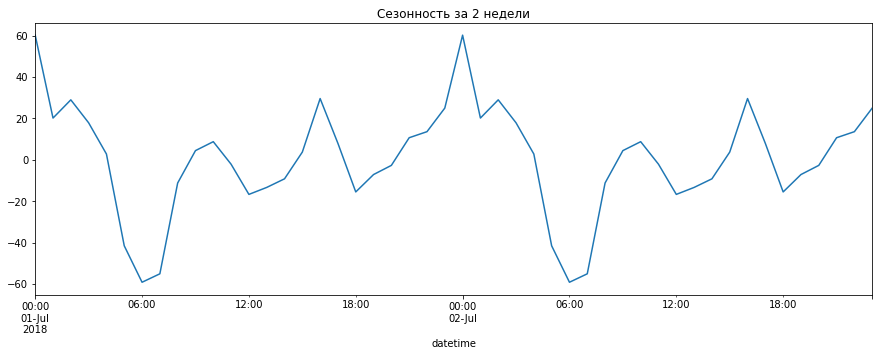

In [11]:
decomposed_data.seasonal['2018-07-01':'2018-07-02'].plot(ax = plt.gca(), title = 'Сезонность за 2 недели', figsize = (15,5))

Посмотрим на данные и тренд decomposed_data

Text(0.5, 1.0, 'Заказы по месяцам')

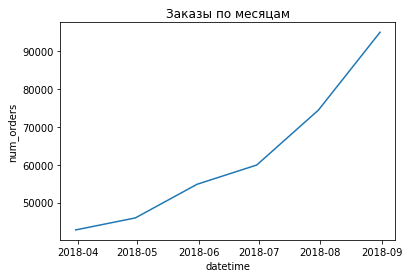

In [12]:
months_2 = decomposed_data
sns.lineplot(x=months.index,y=months['num_orders']).set_title('Заказы по месяцам')

<AxesSubplot:title={'center':'Тренд decomposed_data'}, xlabel='datetime'>

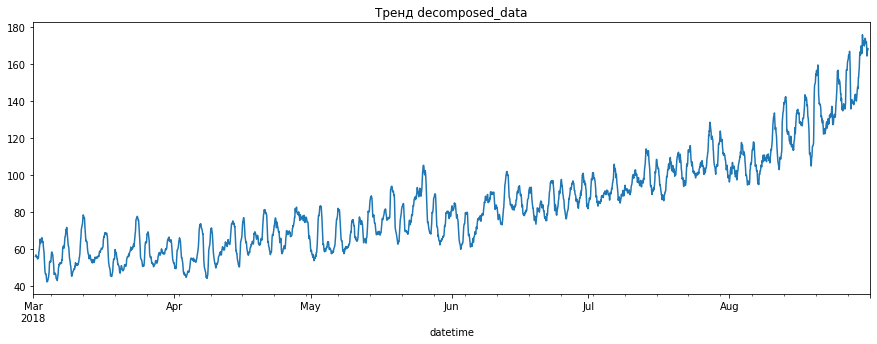

In [13]:
decomposed_data.trend.plot(ax = plt.gca(), title = 'Тренд decomposed_data', figsize = (15,5))

**ВЫВОДЫ**

- Количество заказов увеличевается к началу лета и растёт далее до конца августа (если бы данные были побольше, то может дальше бы и уменьшалось. Хотя в холод тоже мало кто хочет ходить пешком, но в холода увеличивается цена на такси)
- Самое большое количество заказов приходится на вечер/ночь (около 00:00), что не удивительно, так как метро или автобусы престают работать. Идёт спад ближе к 6 утра, так как все модники из баров уже разъехались по домам. А начиная с 9 утра спрос снова растёт, так как не все могут прохлождаться до 6 утра и кому-то с утра на работу

## Обучение

Для обучения нам необходимо создать новые признаки:

- час
- день
- день недели
- месяц



In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    #data['month'] = data.index.month
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    

make_features(data, 8, 8)

In [15]:
data

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,167.375
2018-08-31 20:00:00,154,20,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,163.500
2018-08-31 21:00:00,159,21,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,165.750


In [16]:
train, test = train_test_split(data, shuffle = False, random_state = 12345, test_size = 0.1)


In [17]:
train = train.dropna()
test= test.dropna()

In [18]:
train_target = train['num_orders']
train_features = train.drop(['num_orders'], axis = 1)
test_target = test['num_orders']
test_features = test.drop(['num_orders'], axis = 1)

In [19]:
train.shape

(3966, 12)

In [20]:
test.shape

(442, 12)

In [21]:
train_features.shape

(3966, 11)

In [22]:
test_features.shape

(442, 11)

In [23]:
def rmse_show(model, name):
    model = model
    model.fit(train_features, train_target)
    train_prediction = model.predict(train_features)
    test_preidciton = model.predict(test_features)
    print(name)
    print('RMSE train:', mean_squared_error(train_target,train_prediction )**0.5)
    print('RMSE train:', mean_squared_error(test_target,test_preidciton )**0.5)

## Тестирование

### LGBMRegressor

In [24]:
%%time
rmse_show(LGBMRegressor(), 'LGBMRegressor')

LGBMRegressor
RMSE train: 15.104777446574248
RMSE train: 44.366353755750936
CPU times: user 3min 28s, sys: 3.54 s, total: 3min 32s
Wall time: 3min 33s


### LinearRegression

In [25]:
%%time
rmse_show(LinearRegression(), 'LinearRegression')

LinearRegression
RMSE train: 31.225181849838968
RMSE train: 53.75799116678107
CPU times: user 63.7 ms, sys: 44.4 ms, total: 108 ms
Wall time: 92.7 ms


### RandomForestRegressor

In [26]:
%%time
rmse_show(RandomForestRegressor(), 'RandomForestRegressor')

RandomForestRegressor
RMSE train: 8.826334988790189
RMSE train: 45.74804675503045
CPU times: user 2.15 s, sys: 63.8 ms, total: 2.21 s
Wall time: 2.24 s


CatBoostRegressor

## Подбор параметров 

In [27]:
splits = TimeSeriesSplit(n_splits = 8)

### LGBMRegressor

In [28]:
lgbm_param = {
        'n_estimators' : range(50, 101, 10),
        'max_depth' : range(5, 15, 2),
        'verbose' : [0],
        'random_state' : [12345],
        }

In [29]:
%%time
lgmb_gs = GridSearchCV(LGBMRegressor(),param_grid = lgbm_param, refit = False, scoring = 'neg_mean_squared_error', cv = splits, )
lgmb_gs.fit(train_features, train_target)

lgbm_param_best = lgmb_gs.best_params_
lgb_m = LGBMRegressor(**lgbm_param_best)
lgb_m.fit(train_features, train_target)

lgb_pred = lgb_m.predict(test_features)

print('Лучшие гиперпарметры:',lgbm_param_best )
print('RMSE test:', mean_squared_error(test_target, lgb_pred)**0.5)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

### LinearRegression

In [30]:
linear_reg = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True,False]}

In [31]:
%%time
linear_reg_gs = GridSearchCV(LinearRegression(),param_grid = linear_reg, refit = False, scoring = 'neg_mean_squared_error', cv = splits)
linear_reg_gs.fit(train_features, train_target)


linear_reg_param_best = linear_reg_gs.best_params_
linear_reg_m = LinearRegression(**linear_reg_param_best)
linear_reg_m.fit(train_features, train_target)

linear_reg_pred = linear_reg_m.predict(test_features)

print('Лучшие гиперпарметры:',linear_reg_param_best )
print('RMSE test:', mean_squared_error(test_target, linear_reg_pred)**0.5)


Лучшие гиперпарметры: {'copy_X': True, 'fit_intercept': True, 'normalize': True}
RMSE test: 53.757991166781075
CPU times: user 733 ms, sys: 322 ms, total: 1.05 s
Wall time: 1.09 s


### RandomForestRegressor

In [32]:
random_forest_param = {
    'n_estimators' : range (50,100,10),
    'max_depth': range(5,12,2),
    'verbose': [0],
    'random_state': [12345]
    }  

In [33]:
%%time
random_forest_gs = GridSearchCV(RandomForestRegressor(),param_grid = random_forest_param, refit = False, scoring = 'neg_mean_squared_error', cv = splits)
random_forest_gs.fit(train_features, train_target)


random_forest_param_best = random_forest_gs.best_params_
random_forest_m = RandomForestRegressor(**random_forest_param_best)
random_forest_m.fit(train_features, train_target)

random_forest_pred = random_forest_m.predict(test_features)

print('Лучшие гиперпарметры:',random_forest_param_best )
print('RMSE test:', mean_squared_error(test_target, random_forest_pred)**0.5)


Лучшие гиперпарметры: {'max_depth': 11, 'n_estimators': 70, 'random_state': 12345, 'verbose': 0}
RMSE test: 46.71896480030666
CPU times: user 1min 7s, sys: 279 ms, total: 1min 8s
Wall time: 1min 8s


## Вывод

In [38]:
results = {
    'Model' : ['LGBMRegressor', 'LinearRegression', 'RandomForestRegressor'],
    'RMSE на тестовой выборке' :pd.Series([45.14,  53.75, 46.71]),
    'Время обучения: sec': pd.Series([0.89, 0.09,  2.45]),
    }
display(pd.DataFrame(results))

,Model,RMSE на тестовой выборке,Время обучения: sec
0,LGBMRegressor,45.14,0.89
1,LinearRegression,53.75,0.09
2,RandomForestRegressor,46.71,2.45


Исходя из полученных результатов, наилучшим выбором модели удовлетворяющее условию, что RMSE должно быть меньше 48 будет - LGBMRegressor. У нас есть и вторая модель удовлетворяющуя данному условию, но так как время обучения у RandomForestRegressor ниже, то выбор будем делать в пользу LGBMRegressor.

LGBMRegressor

<AxesSubplot:xlabel='datetime', ylabel='num_orders'>

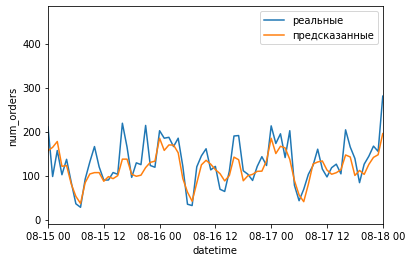

In [40]:
plt.xlim(pd.Timestamp('2018-08-15'), pd.Timestamp('2018-08-18'))

sns.lineplot(x= test_target.index,
                 y= test_target, label = 'реальные')
sns.lineplot(x= test_target.index,
                 y= lgb_pred, label = 'предсказанные')

LinearRegression

<AxesSubplot:xlabel='datetime', ylabel='num_orders'>

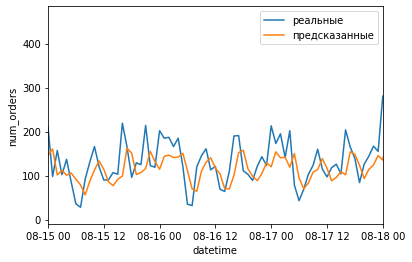

In [41]:
plt.xlim(pd.Timestamp('2018-08-15'), pd.Timestamp('2018-08-18'))

sns.lineplot(x= test_target.index,
                 y= test_target, label = 'реальные')
sns.lineplot(x= test_target.index,
                 y= linear_reg_pred, label = 'предсказанные')

RandomForestRegressor¶

<AxesSubplot:xlabel='datetime', ylabel='num_orders'>

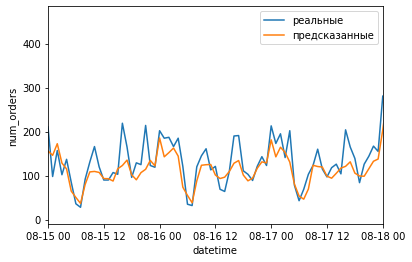

In [42]:
plt.xlim(pd.Timestamp('2018-08-15'), pd.Timestamp('2018-08-18'))

sns.lineplot(x= test_target.index,
                 y= test_target, label = 'реальные')
sns.lineplot(x= test_target.index,
                 y= random_forest_pred, label = 'предсказанные')